In [1]:
import torchvision
import os
import glob
import json
import torch
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.decomposition import PCA
import numpy as np
from sklearn.decomposition import IncrementalPCA
import time
from tqdm import tqdm
import kagglehub
from torch import nn
import logging

# Dataset

In [2]:
root = kagglehub.dataset_download("ambityga/imagenet100")
print("Path to dataset files:", root)

100%|██████████| 16.1G/16.1G [02:39<00:00, 109MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/ambityga/imagenet100/versions/8


In [3]:
class ImageNet100Dataset(torch.utils.data.Dataset):
    def __init__(self, root="/home/malick/datasets/imagenet-100", train:bool=True, transforms=None, num_labels: int = None):
        with open(os.path.join(root, "Labels.json"), "r") as f:
            labels = json.load(f)

        if num_labels is not None:
            labels = dict(sorted(labels.items(), key=lambda v: v[0])[:num_labels])
        self.labels = {k: (v,i) for i, (k,v) in enumerate(labels.items())}
        self.num_classes = len(self.labels)
        self.labels_idx2str = {i: v[0] for i,v in enumerate(self.labels.values())}
        set_name = "train" if train else "val"
        self.files = glob.glob(f"{root}/{set_name}*/*/*.JPEG", recursive=True)
        if num_labels is not None:
            self.files = [f for f in self.files if os.path.basename(os.path.dirname(f)) in self.labels]

        self.transforms = transforms

    def __getitem__(self, idx):
        path = self.files[idx]
        label = self.labels[path.split("/")[-2]][1]
        img = Image.open(path).convert("RGB")
        if self.transforms is not None:
            img = self.transforms(img)
        return img, label

    def __len__(self): return len(self.files)

    def __str__(self): return "ImageNet100Dataset"
    def __repr__(self): return "ImageNet100Dataset"


In [4]:
class ImageNet100:
    def __init__(self, root="/home/malick/datasets/imagenet-100", batch_size=128, num_workers=2, transforms=None, num_labels:int=None):
        self.train = ImageNet100Dataset(train=True, root=root, transforms=transforms, num_labels=num_labels)
        eval_transforms = torchvision.transforms.Compose([
            torchvision.transforms.Resize(size=256),
            torchvision.transforms.CenterCrop(size=224),
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        self.eval = ImageNet100Dataset(train=False, root=root, transforms=eval_transforms, num_labels=num_labels)

        self.labels = self.train.labels
        self.num_classes = self.train.num_classes
        self.labels_idx2str = self.train.labels_idx2str
        self.batch_size = batch_size
        self.num_workers = num_workers

        self.train_dataloader = self.get_dataloader(train=True)
        self.eval_dataloader = self.get_dataloader(train=False)

    def get_dataloader(self, train:bool):
        return torch.utils.data.DataLoader(
            dataset=self.train if train else self.eval, shuffle=train,
            batch_size=self.batch_size, num_workers=self.num_workers)

    def show_images(self, images, labels):
        fig, axes = plt.subplots(4, 5, figsize=(19.8,10.2))
        axes = axes.ravel()
        for i in range(len(axes)):
            axes[i].imshow(images[i], cmap="gray")
            axes[i].set_xticks([])
            axes[i].set_yticks([])
            axes[i].set_title(labels[i].split(",")[0], fontsize=10)
        plt.show()

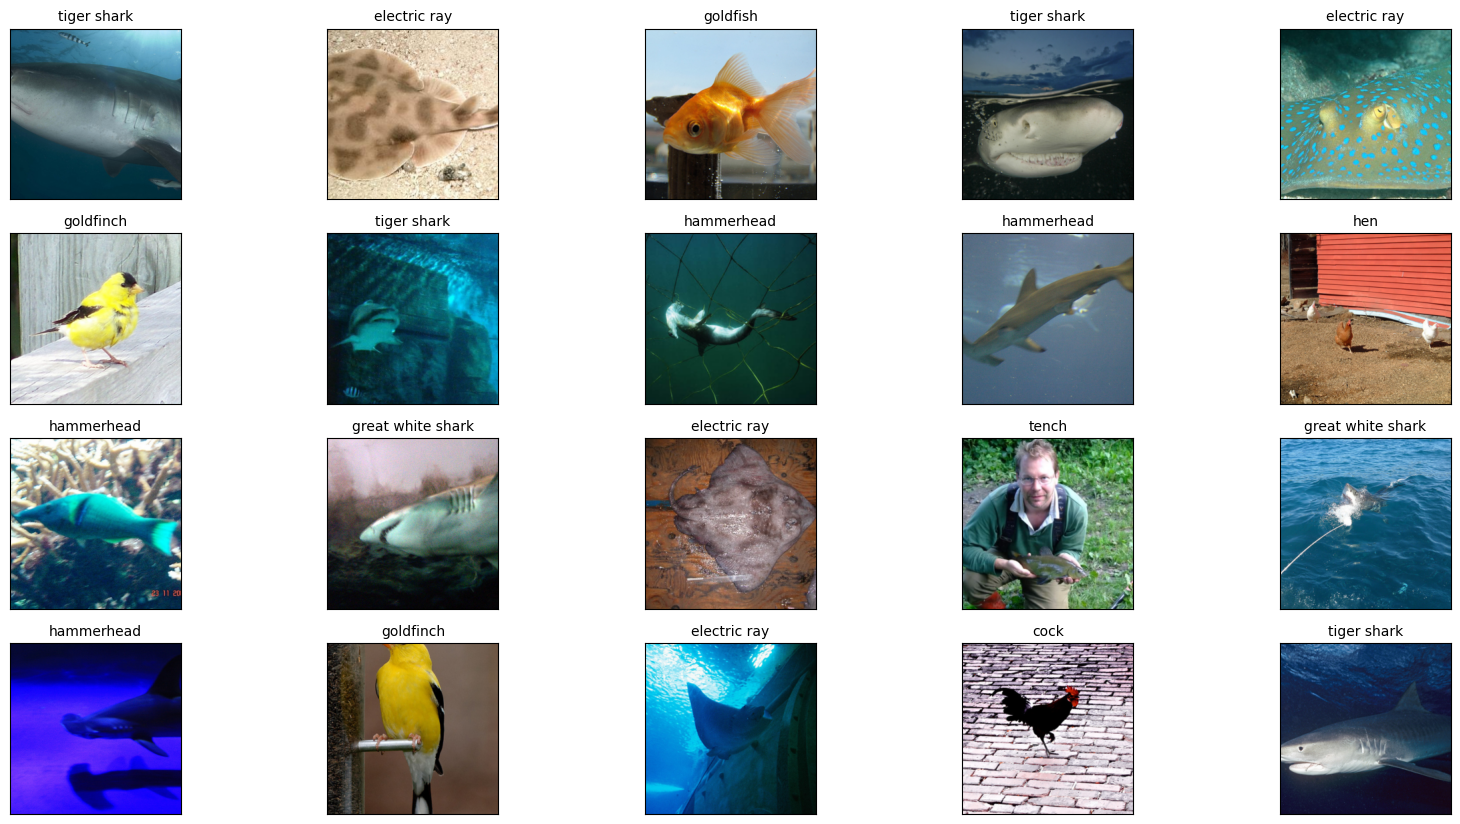

torch.Size([32, 3, 256, 256])


In [5]:
transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=256),
    torchvision.transforms.CenterCrop(size=256),
    torchvision.transforms.ToTensor()
])
data = ImageNet100(root=root, batch_size=32, transforms=transforms, num_labels=10)
for batch in data.train_dataloader:
    x, y = batch
    labels = [data.labels_idx2str[yi] for yi in y.numpy()]
    data.show_images(x.permute(0,2,3,1)[:20], labels)
    print(x.shape); break

In [6]:
for v in data.labels.values():
    print(v[0])

tench, Tinca tinca
goldfish, Carassius auratus
great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias
tiger shark, Galeocerdo cuvieri
hammerhead, hammerhead shark
electric ray, crampfish, numbfish, torpedo
stingray
cock
hen
goldfinch, Carduelis carduelis


In [7]:
def pca_imagenet_100(root: str, num_labels: int = None, batch_size: int = 128):
    if os.path.exists("imagenet-100-pca.json"):
      return
    start = time.time()

    transforms = torchvision.transforms.Compose([
        torchvision.transforms.Resize(size=256),
        torchvision.transforms.CenterCrop(size=256),
        torchvision.transforms.ToTensor(),
    ])
    data = ImageNet100(root=root, transforms=transforms, batch_size=batch_size, num_labels=num_labels)

    ipca = IncrementalPCA(n_components=3)

    for images, _ in tqdm(data.train_dataloader):
        batch = images.permute(0, 2, 3, 1).reshape(-1, 3)
        ipca.partial_fit(batch.numpy())

    eigvals = ipca.explained_variance_
    eigvecs = ipca.components_.T

    with open("imagenet-100-pca.json", "w") as f:
        json.dump({
            "eigvecs": eigvecs.tolist(),
            "eigvals": eigvals.tolist(),
        }, f)

    duration = time.time() - start
    print(f"PCA took {duration:.5f} seconds")

    print("PCA eigvals and eigvecs on Imagenet-100 are saved into imagenet-100-pca.json")


In [8]:
pca_imagenet_100(root=root, batch_size=256, num_labels=10)

100%|██████████| 51/51 [03:51<00:00,  4.54s/it]

PCA took 232.01465 seconds
PCA eigvals and eigvecs on Imagenet-100 are saved into imagenet-100-pca.json


In [9]:
class FancyPCA:
    def __init__(self, file="imagenet-100-pca.json"):
        with open(file, "r") as f:
            pca_data = json.load(f)
        self.eigvecs = torch.tensor(pca_data["eigvecs"])
        self.eigvals = torch.tensor(pca_data["eigvals"])

    def __call__(self, img: torch.Tensor) -> torch.Tensor:
        alphas = torch.zeros(size=(3,)).normal_(mean=0., std=0.1)
        rgb = (self.eigvecs @ (alphas * self.eigvals)).view(3, 1, 1)
        img += rgb
        return torch.clamp(img, 0., 1.)

In [10]:
train_transforms = torchvision.transforms.Compose([
        torchvision.transforms.Resize(size=256),
        torchvision.transforms.CenterCrop(size=256),
        torchvision.transforms.RandomCrop(size=(224,224)),
        torchvision.transforms.ToTensor(),
        FancyPCA(),
        torchvision.transforms.RandomHorizontalFlip(p=0.5),
        torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

batch_size = 256
num_labels = 10

data = ImageNet100(root=root, transforms=train_transforms, batch_size=batch_size, num_labels=num_labels)

# Model

In [19]:
class AlexNet(nn.Module):
    def __init__(self, num_classes: int=100):
        super(AlexNet, self).__init__()

        self.net = nn.Sequential(
            # For (227x227) images
            # nn.Conv2d(in_channels=3, out_channels=96, kernel_size=11, stride=4, padding=0, bias=False), nn.ReLU(),   # (B, 96, 55, 55)

            nn.Conv2d(in_channels=3, out_channels=96, kernel_size=11, stride=4, padding=2, bias=False), nn.ReLU(),   # (B, 96, 55, 55)
            nn.LocalResponseNorm(size=5, k=2, alpha=1e-4, beta=0.75),                                                # (B, 96, 55, 55)
            nn.MaxPool2d(kernel_size=3, stride=2),                                                                   # (B, 96, 27, 27)
            nn.Conv2d(in_channels=96, out_channels=256, kernel_size=5, stride=1, padding=2, bias=1.), nn.ReLU(),     # (B, 256, 27, 27)
            nn.LocalResponseNorm(size=5, k=2, alpha=1e-4, beta=0.75),                                                # (B, 256, 27, 27)
            nn.MaxPool2d(kernel_size=3, stride=2),                                                                   # (B, 256, 13, 13)
            nn.Conv2d(in_channels=256, out_channels=384, kernel_size=3, stride=1, padding=1, bias=False), nn.ReLU(), # (B, 384, 13, 13)
            nn.Conv2d(in_channels=384, out_channels=384, kernel_size=3, stride=1, padding=1, bias=1.), nn.ReLU(),    # (B, 384, 13, 13)
            nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, stride=1, padding=1, bias=1.), nn.ReLU(),    # (B, 256, 13, 13)
            nn.MaxPool2d(kernel_size=3, stride=2),                                                                   # (B, 256, 6, 6)
            nn.Flatten(),                                                                                            # (B, 9216)
            nn.Linear(in_features=9216, out_features=4096, bias=1.), nn.ReLU(), nn.Dropout(0.5),                     # (B, 4096)
            nn.Linear(in_features=4096, out_features=4096, bias=1.), nn.ReLU(), nn.Dropout(0.5),                     # (B, 4096)
            nn.Linear(in_features=4096, out_features=num_classes, bias=1.)                                           # (B, num_classes)
        )

        self.init()


    def init(self):
        for layer in self.net:
            if isinstance(layer, nn.Conv2d) or isinstance(layer, nn.Linear):
                torch.nn.init.normal_(tensor=layer.weight, mean=0., std=0.01)

    def forward(self, x):
        return self.net(x)


In [27]:
x = torch.randn((1, 3, 224, 224))
model = AlexNet(num_classes=num_labels)
output = model(x)
print("Model:\n", model, "\n")
print("input shape:", x.shape)
print("output shape:", output.shape)

Model:
 AlexNet(
  (net): Sequential(
    (0): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2), bias=False)
    (1): ReLU()
    (2): LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=2)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (5): ReLU()
    (6): LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=2)
    (7): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (9): ReLU()
    (10): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=9216, out_features=4096, b

In [28]:
def compute_number_params(model):
    num_total_params = 0
    for _, params in model.named_parameters():
        if params.requires_grad:
            num_total_params += params.numel()
    return num_total_params

In [29]:
print("Number of parameters of AlexNet:", compute_number_params(model))

Number of parameters of AlexNet: 58321834


# Trainer

In [30]:
class Writer:
    def __init__(self, fname: str):
        self.fname = fname
        self.metrics = {}

    def add(self, step, metric_name, value):
        if not metric_name in self.metrics:
            self.metrics[metric_name] = {}
        self.metrics[metric_name][step] = value

    def save(self):
        with open(self.fname+".json", "w") as f:
            json.dump(self.metrics, f)

In [31]:
def train(device, model, data, optimizer, scheduler, max_epochs, log_every=10):
    model_name = model.__class__.__name__.lower()
    model = model.to(device)

    print(f"Device: {device}")
    print(f"Train dataset: {data.train} - {len(data.train)} instances")
    print(f"Eval dataset: {data.eval} - {len(data.eval)} instances")

    criterion = nn.CrossEntropyLoss()
    train_dataloader=data.train_dataloader
    eval_dataloader=data.eval_dataloader

    overall_metrics = {
        "train_loss": [],
        "eval_loss": [],
        "train_accuracy": [],
        "eval_accuracy": [],
        "train_step": [],
        "eval_step": []
    }

    best_acc = 0

    writer = Writer(fname=model_name)
    setattr(writer, "num_train_batches", len(train_dataloader))
    setattr(writer, "max_epochs", max_epochs)

    writer.metrics["num_train_batches"] = len(train_dataloader)
    writer.metrics["max_epochs"] = max_epochs

    def fit_epoch(epoch_num):
        train_loss = 0.
        eval_loss = 0.
        train_acc = 0.
        eval_acc = 0.
        train_instances = 0
        eval_instances = 0

        model.train()

        for step_num, batch in enumerate(train_dataloader):
            batch = [a.to(device) for a in batch]
            output = model(*batch[:-1])

            optimizer.zero_grad()
            loss = criterion(output, batch[-1])
            loss.backward()
            optimizer.step()

            train_instances += batch[-1].size(0)
            train_loss += loss.item() * batch[-1].size(0)
            acc = (batch[-1]==output.argmax(dim=-1)).float().mean() * batch[-1].size(0)
            train_acc += acc.item()
            avg_loss = train_loss / train_instances
            avg_acc = train_acc / train_instances


            overall_metrics["train_loss"].append(avg_loss)
            overall_metrics["train_accuracy"].append(avg_acc)
            global_step = (epoch_num*len(train_dataloader)) + step_num
            overall_metrics["train_step"].append(global_step)

            writer.add(step=global_step, metric_name="Loss/train", value=avg_loss)
            writer.add(step=global_step, metric_name="Accuracy/train", value=avg_acc)

            if step_num % log_every == 0:
                print(f"[Epoch {epoch_num+1}/{max_epochs}] [Step {global_step}/{len(train_dataloader)}] train_loss: {avg_loss:.5f}, train_acc: {avg_acc:.5f}")


        model.eval()

        for step_num, batch in enumerate(eval_dataloader):
            batch = [a.to(device) for a in batch]
            with torch.no_grad():
                output = model(*batch[:-1])

                loss = criterion(output, batch[-1])

                eval_instances += batch[-1].size(0)
                eval_loss += loss.item() * batch[-1].size(0)
                acc = (batch[-1]==output.argmax(dim=-1)).float().mean() * batch[-1].size(0)
                eval_acc += acc.item()
                avg_loss = eval_loss / eval_instances
                avg_acc = eval_acc / eval_instances

                overall_metrics["eval_loss"].append(avg_loss)
                overall_metrics["eval_accuracy"].append(avg_acc)
                global_step = (epoch_num*len(eval_dataloader)) + step_num
                overall_metrics["eval_step"].append(global_step)

        train_loss = train_loss / train_instances
        train_acc = train_acc / train_instances
        eval_loss = eval_loss / eval_instances
        eval_acc = eval_acc / eval_instances

        writer.add(step=epoch_num, metric_name="Loss/eval", value=eval_loss)
        writer.add(step=epoch_num, metric_name="Accuracy/eval", value=eval_acc)

        print(f"[Epoch {epoch_num+1}/{max_epochs}] train_loss: {train_loss:.5f}, train_acc: {train_acc:.5f}, eval_loss: {eval_loss:.5f}, eval_acc: {eval_acc:.5f}")
        scheduler.step(eval_loss)
        torch.save(model, f"{model_name}.pth")
        print(f"Model saved at {model_name}.pth")

        return eval_acc

    for epoch_num in range(max_epochs):
        eval_acc = fit_epoch(epoch_num)

        if eval_acc > best_acc:
            best_acc = eval_acc
            torch.save(model.state_dict(), f"best-{model_name}.pth")

    writer.save()
    return overall_metrics


# Train

In [32]:
learning_rate = 0.01
momentum = 0.9
weight_decay = 0.0005
max_epochs = 90
log_every = 25
optimizer = torch.optim.SGD(lr=learning_rate, params=model.parameters(), momentum=momentum, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, mode="min", factor=0.1)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Device: cuda
Train dataset: ImageNet100Dataset - 13000 instances
Eval dataset: ImageNet100Dataset - 500 instances
[Epoch 1/90] [Step 0/51] train_loss: 2.30306, train_acc: 0.09375
[Epoch 1/90] [Step 25/51] train_loss: 2.30269, train_acc: 0.10231
[Epoch 1/90] [Step 50/51] train_loss: 2.30269, train_acc: 0.09931
[Epoch 1/90] train_loss: 2.30269, train_acc: 0.09931, eval_loss: 2.30236, eval_acc: 0.10000
Model saved at alexnet.pth
[Epoch 2/90] [Step 51/51] train_loss: 2.30233, train_acc: 0.12500
[Epoch 2/90] [Step 76/51] train_loss: 2.30241, train_acc: 0.10412
[Epoch 2/90] [Step 101/51] train_loss: 2.30253, train_acc: 0.09985
[Epoch 2/90] train_loss: 2.30253, train_acc: 0.09985, eval_loss: 2.30193, eval_acc: 0.21400
Model saved at alexnet.pth
[Epoch 3/90] [Step 102/51] train_loss: 2.30251, train_acc: 0.08984
[Epoch 3/90] [Step 127/51] train_loss: 2.30191, train_acc: 0.12064
[Epoch 3/90] [Step 152/51] train_loss: 2.30177, train_acc: 0.12000
[Epoch 3/90] train_loss: 2.30177, train_acc: 0.1200

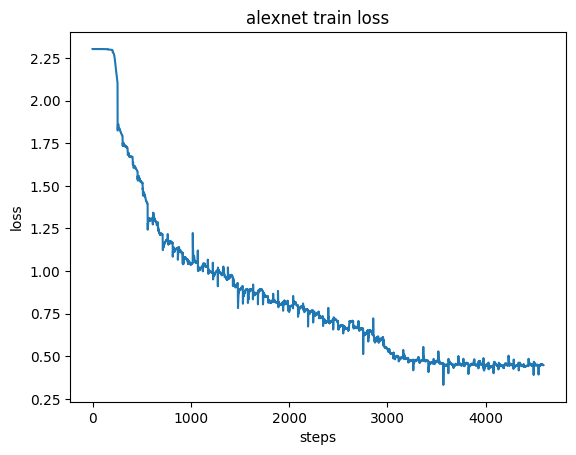

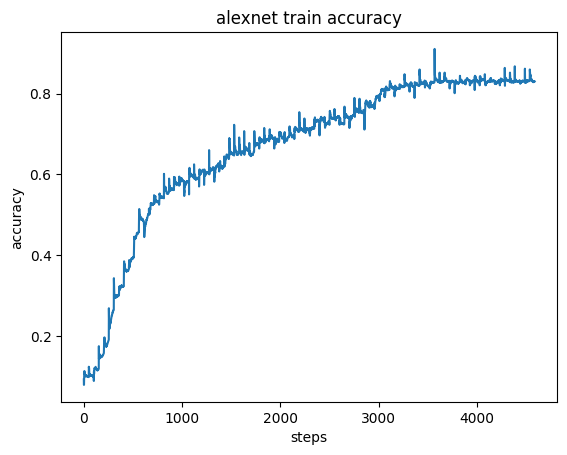

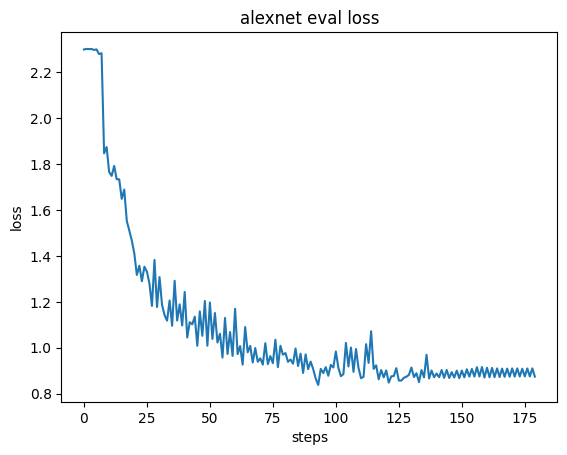

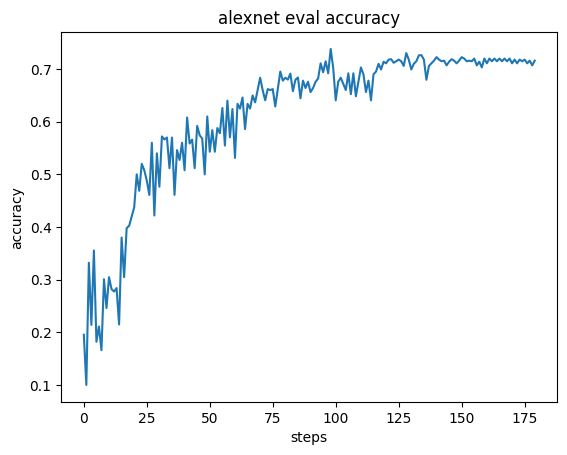

In [33]:
overall_metrics = train(
    device=device,
    model=model,
    data=data,
    optimizer=optimizer,
    scheduler=scheduler,
    max_epochs=max_epochs,
    log_every=log_every,
)
for set_name in ["train", "eval"]:
    for metric in ["loss", "accuracy"]:
        plt.plot(overall_metrics[f"{set_name}_step"], overall_metrics[f"{set_name}_{metric}"])
        plt.xlabel("steps")
        plt.ylabel(f"{metric}")
        plt.title(f"alexnet {set_name} {metric}")
        plt.show(block=False)
        plt.pause(5)
        plt.savefig(f"{set_name}-{metric}.png")
        plt.close()